<!-- # 학습 개선방향
### 데이터 
- `04_014_FE.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
    - date_block_num >= 12 로 데이터 고정
    - test 데이터에 존재하는 item_id로 데이터 필터링
    - item_name에 대한 파생 피처 생성
### 학습
- 학습 결과 평가
    - 모델의 예측값과 타겟값을 직접 비교
    - 예측값과 타겟값의 차이가 큰 데이터를 직접 확인
    - 검증(10월) 데이터에 대한 예측값의 평균보다 테스트(11월) 데이터에 대한 예측값의 평균이 낮아야 함. 데이터를 통해 11월의 매출이 1년 중 가장 낮은 것을 확인 -->

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation, record_evaluation
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

%matplotlib inline
plt.style.use("seaborn-v0_8-white")
pd.options.display.float_format = '{:.6f}'.format

 # Data

In [ ]:
data_path = "./data/"

# old_one = joblib.load(data_path + 'all_data2.joblib')
all_data = joblib.load(data_path + 'all_data_result.joblib')
test = pd.read_csv(data_path + 'test.csv')
all_data.shape, test.shape

((8812167, 38), (214200, 3))

In [3]:
print(all_data.duplicated(subset=['date_block_num', 'shop_id', 'item_id']).sum())
print(all_data['date_block_num'].min())

0
0


In [4]:
temp = all_data.isna().sum()
print(temp[temp > 0])
del temp

date_item_avg_price_lag_1    2027634
rolling_3m_price_mean        1194831
dtype: int64


In [7]:
sorted(all_data.columns.tolist())

['category_nov_ratio',
 'city',
 'city_item_avg_date_sales_lag_1',
 'date_block_num',
 'date_item_avg_price_lag_1',
 'delta_price_lag',
 'item_age',
 'item_avg_date_sales_diff_1',
 'item_avg_date_sales_diff_2',
 'item_avg_date_sales_lag_1',
 'item_avg_date_sales_lag_2',
 'item_category_avg_date_sales_lag_1',
 'item_category_avg_date_sales_lag_2',
 'item_category_id',
 'item_cnt_month',
 'item_cnt_month_diff_1',
 'item_cnt_month_diff_2',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_id',
 'item_shop_age',
 'item_shop_last_sale',
 'meta',
 'month',
 'new_item_effect',
 'platform',
 'rolling_3m_cnt_mean',
 'rolling_3m_cnt_std',
 'rolling_3m_item_cat_mean',
 'rolling_3m_item_mean',
 'rolling_3m_item_std',
 'rolling_3m_price_mean',
 'shop_id',
 'shop_item_category_avg_date_sales_lag_1',
 'transaction_cnt_lag_1',
 'transaction_cnt_lag_2',
 'type_code']

# Model

## Optuna

In [ ]:
drop_cols = ['item_cnt_month', 'item_avg_date_sales_lag_1', 'item_category_avg_date_sales_lag_2', ] # 
val_month = 33

train_mask = all_data['date_block_num'] < val_month
x_train = all_data.loc[train_mask].drop(drop_cols, axis=1)

val_mask = all_data['date_block_num'] == val_month
x_val = all_data.loc[val_mask].drop(drop_cols, axis=1)

y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)

test_mask = all_data['date_block_num'] == 34
x_test = all_data.loc[test_mask].drop(drop_cols, axis=1)

print(f'학습데이터 : {x_train.shape}')

cat_features = ['shop_id', 'item_category_id', 'city', \
    'type_code', 'platform', 'month', 'meta', ] #  

dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

학습데이터 : (8376165, 35)


In [9]:
%%time

fixed_params = {
    'objective': 'tweedie',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_pre_filter': False,
    'force_col_wise': True,
    'random_state': 2025,
    'n_jobs': -1,
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05), 
        'num_leaves': trial.suggest_int('num_leaves', 60, 150),
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.05, 1.15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 10, 14),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 600),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=5000,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'eval'],
        callbacks=[
            early_stopping(stopping_rounds=300),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    trial.set_user_attr("best_iter", lgb_model.best_iteration)
    
    preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration)
    preds = preds.clip(0, 20)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

[I 2025-12-13 15:23:46,656] A new study created in memory with name: no-name-df19adb4-e16d-46d7-a6be-30d62f6ba4a1


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[852]	train's rmse: 0.78693	eval's rmse: 0.783591
[I 2025-12-13 15:45:43,561] Trial 0 finished with value: 0.7835692669946148 and parameters: {'learning_rate': 0.015419526547118471, 'num_leaves': 140, 'tweedie_variance_power': 1.1432605639886502, 'feature_fraction': 0.7336704492142785, 'bagging_fraction': 0.7164706638341948, 'bagging_freq': 2, 'max_depth': 13, 'min_child_samples': 346, 'reg_alpha': 4.821192096250286, 'reg_lambda': 4.0049223743472}. Best is trial 0 with value: 0.7835692669946148.
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[434]	train's rmse: 0.790378	eval's rmse: 0.79184
[I 2025-12-13 16:01:38,860] Trial 1 finished with value: 0.7917997348243168 and parameters: {'learning_rate': 0.02820821140838299, 'num_leaves': 132, 'tweedie_variance_power': 1.0541717972818752, 'feature_fraction': 0.8308373615813435, 'bagging_fraction':

Wall time: 53min 36s

In [10]:
print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Iteration : {study_lgbm.best_trial.user_attrs['best_iter']}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('=='*20,'Best Parameters', '=='*20)
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

Total Trials : 50
Best Trial : 42
Best Iteration : 446
Best Score : 0.77229
======================================== Best Parameters ========================================
learning_rate : 0.04239550533618649
num_leaves : 126
tweedie_variance_power : 1.0654784315273522
feature_fraction : 0.6618000231456961
bagging_fraction : 0.6289166043813048
bagging_freq : 5
max_depth : 12
min_child_samples : 373
reg_alpha : 4.381082344707673
reg_lambda : 4.770823562494472


/tmp/ipykernel_2589/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

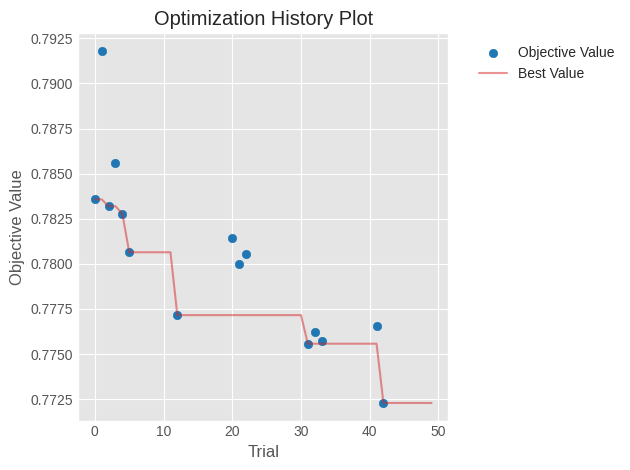

In [11]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_9569/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

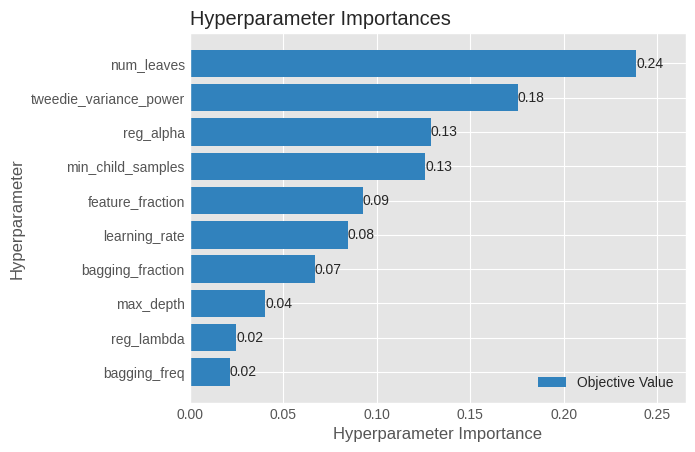

In [21]:
plot_param_importances(study_lgbm)

In [12]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)
best_iter = study_lgbm.best_trial.user_attrs['best_iter']
print(f"Best params: {best_params}")
print(f"Best iteration: {best_iter}")

Best params: {'learning_rate': 0.04239550533618649, 'num_leaves': 126, 'tweedie_variance_power': 1.0654784315273522, 'feature_fraction': 0.6618000231456961, 'bagging_fraction': 0.6289166043813048, 'bagging_freq': 5, 'max_depth': 12, 'min_child_samples': 373, 'reg_alpha': 4.381082344707673, 'reg_lambda': 4.770823562494472, 'objective': 'tweedie', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'force_col_wise': True, 'random_state': 2025, 'n_jobs': -1}
Best iteration: 446


## Validation

In [ ]:
# drop_cols = ['item_cnt_month', 'is_first_month', 'days', 'month_sin', 'month_cos', 'shop_avg_date_sales_lag_1', \
#     'delta_shop_revenue_lag', 'item_avg_price_expanding', 'item_category_expanding_mean', 'item_expanding_mean', 'shop_expanding_mean', 'item_month_mean_expanding', 'shop_category_month_mean_expanding', \
#     'num_weekends', ] # 
# drop_cols = ['item_cnt_month', 'month_sin', 'month_cos',  'item_avg_price_expanding', 'subtype', \
#     'item_avg_date_sales_lag_1', 'rolling_3m_item_cat_std', 'rolling_3m_price_std', 'new_item_cat_avg_lag_1', \
#         'items_per_transaction_lag_1', ] # 'item_avg_date_sales_diff_2'

In [8]:
all_data['date_block_num'].min()

0

In [9]:
drop_cols = ['item_cnt_month', 'item_avg_date_sales_lag_1', 'item_category_avg_date_sales_lag_2', ] # 
val_month = 33

train_mask = all_data['date_block_num'] < val_month
x_train = all_data.loc[train_mask].drop(drop_cols, axis=1)

val_mask = all_data['date_block_num'] == val_month
x_val = all_data.loc[val_mask].drop(drop_cols, axis=1)

y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)

test_mask = all_data['date_block_num'] == 34
x_test = all_data.loc[test_mask].drop(drop_cols, axis=1)

print(f'학습데이터 : {x_train.shape}')

cat_features = ['shop_id', 'item_category_id', 'city', \
    'type_code', 'platform', 'month', 'meta', ] #  

# tunning
best_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.0654, # 1.0654
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'n_jobs': -1,
    'learning_rate': 0.01, 
    'feature_fraction' : 0.6618,
    'bagging_fraction': 0.6289,
    'bagging_freq': 5,
    'reg_alpha': 0.1, # 4.3811 - 0.5
    'reg_lambda': 0.5, # 4.7708
    'num_leaves' : 225, # 126, 200
    'min_child_samples' : 50, # 373 - 200 - 100 - 50
    'max_depth' : 12,
}

data_params = best_params.copy()
data_params['data_random_seed'] = 2025

dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features, params=data_params)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain, params=data_params)

# manual
# best_params = {
#     'objective': 'tweedie',
#     'tweedie_variance_power': 1.1,
#     'metric': 'rmse',
#     'force_col_wise': True,
#     'random_state': 2025,
#     'verbosity': -1,
#     'learning_rate': 0.01, 
#     'feature_fraction' : 0.7, 
#     'bagging_fraction': 0.7,
#     'bagging_freq': 1,
#     'reg_alpha': 0.1, 
#     'reg_lambda': 0.5, 
#     'num_leaves' : 200, # 200
#     'min_child_samples' : 50,
#     'max_depth' : 12, 
# }

학습데이터 : (8376165, 35)


In [10]:
%%time
evals_result = {}

val_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'eval'],
    callbacks=[
        log_evaluation(period=100),
        early_stopping(stopping_rounds=300),
        record_evaluation(evals_result)
    ]
)

Training until validation scores don't improve for 300 rounds
[100]	train's rmse: 0.960787	eval's rmse: 0.852619
[200]	train's rmse: 0.867928	eval's rmse: 0.800587
[300]	train's rmse: 0.835702	eval's rmse: 0.792933
[400]	train's rmse: 0.818088	eval's rmse: 0.79289
[500]	train's rmse: 0.80699	eval's rmse: 0.791282
[600]	train's rmse: 0.797764	eval's rmse: 0.790414
[700]	train's rmse: 0.789833	eval's rmse: 0.790223
[800]	train's rmse: 0.782116	eval's rmse: 0.790783
[900]	train's rmse: 0.775896	eval's rmse: 0.791065
[1000]	train's rmse: 0.769692	eval's rmse: 0.790074
[1100]	train's rmse: 0.764489	eval's rmse: 0.789867
[1200]	train's rmse: 0.759629	eval's rmse: 0.789454
[1300]	train's rmse: 0.755283	eval's rmse: 0.789413
[1400]	train's rmse: 0.75137	eval's rmse: 0.789234
[1500]	train's rmse: 0.74765	eval's rmse: 0.789414
Early stopping, best iteration is:
[1253]	train's rmse: 0.757272	eval's rmse: 0.788728
CPU times: user 1h 19min 56s, sys: 9.08 s, total: 1h 20min 5s
Wall time: 21min 51s


In [ ]:
# 파라미터 튜닝 전 ) 구조 확정
# [1104] train's rmse: 0.772838	eval's rmse: 0.785262  | LB : 0.85822 ***************** BEST **********
##################################
# optuna 튜닝
# [1800] train's rmse: 0.809551	eval's rmse: 0.786367 | LB : 0.87062 -> 과소학습 -> 33월에 최적화 하다보니 파라미터가 보수적으로 설정됨
# num_leaves 225, min_child_samples 50, 
# [1253] train's rmse: 0.757272	eval's rmse: 0.788728 | LB : 0.85704 **************** BEST ***********
# lr 0.005
# [1945] train's rmse: 0.771739	eval's rmse: 0.783701 | LB : 0.86414
# lr 0.015
# 796]	train's rmse: 0.760235	eval's rmse: 0.784938 | LB : 0.85842

In [ ]:
### BEST #####
# [100]	train's rmse: 0.960787	eval's rmse: 0.852619
# [200]	train's rmse: 0.867928	eval's rmse: 0.800587
# [300]	train's rmse: 0.835702	eval's rmse: 0.792933
# [400]	train's rmse: 0.818088	eval's rmse: 0.79289
# [500]	train's rmse: 0.80699	eval's rmse: 0.791282
# [600]	train's rmse: 0.797764	eval's rmse: 0.790414
# [700]	train's rmse: 0.789833	eval's rmse: 0.790223
# [800]	train's rmse: 0.782116	eval's rmse: 0.790783
# [900]	train's rmse: 0.775896	eval's rmse: 0.791064
# [1000]	train's rmse: 0.769692	eval's rmse: 0.790073
# [1100]	train's rmse: 0.764489	eval's rmse: 0.789866
# [1200]	train's rmse: 0.759629	eval's rmse: 0.789453
# [1300]	train's rmse: 0.755283	eval's rmse: 0.789412
# [1400]	train's rmse: 0.75137	eval's rmse: 0.789234
# [1500]	train's rmse: 0.74765	eval's rmse: 0.789413
# Early stopping, best iteration is:
# [1253]	train's rmse: 0.757272	eval's rmse: 0.788728

In [ ]:
# item_cats_per_transaction_lag_1
# item_last_sale : 전상점 통틀어 마지막 판매

# # item_avg_date_sales_diff_2 제거 (퍼뮤테이션 확인)
# [497]	train's rmse: 0.816491	eval's rmse: 0.790802  | LB : 0.87171 -> 파라미터 최적화 후에 다시 해볼 것

In [11]:
print('Best score: ', val_lgbm_model.best_score['eval']['rmse'])
print('Best iteration: ', val_lgbm_model.best_iteration)

Best score:  0.78872812136392
Best iteration:  1253


> LB : 0.85704

In [16]:
val_preds = val_lgbm_model.predict(x_val, num_iteration=val_lgbm_model.best_iteration).clip(0, 20)
print(f'CV Prediction Mean  :{val_preds.mean()}')
print(f'Validation Mean     :{y_val.mean()}')
print(len(val_preds[val_preds < 0.3]) / len(val_preds))
print(len(y_val[y_val < 0.3]) / len(y_val))

CV Prediction Mean  :0.24604597645312515
Validation Mean     :0.2576667478201279
0.8205877314000776
0.8616108060342107


## Learning Curve

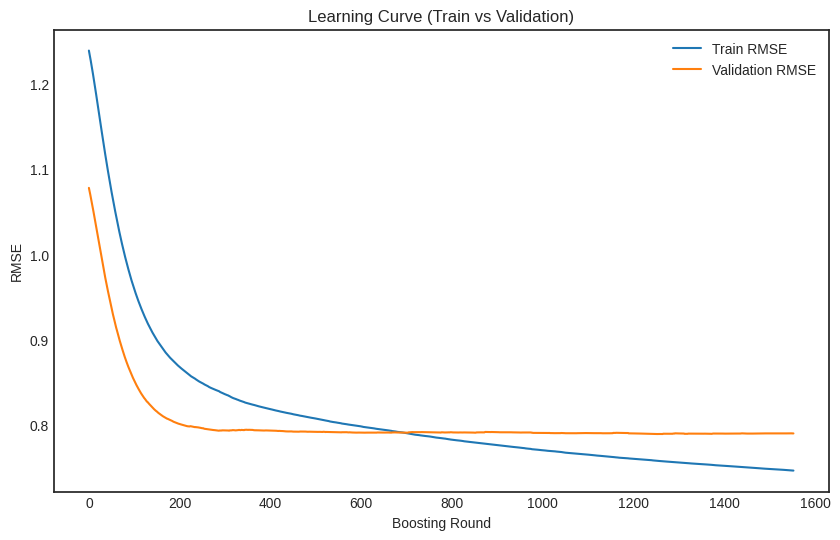

In [17]:
metric = 'rmse' 
train_metric = evals_result['train'][metric]
val_metric = evals_result['eval'][metric]
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(len(train_metric)), y=train_metric, label='Train RMSE')
sns.lineplot(x=range(len(val_metric)), y=val_metric, label='Validation RMSE')
plt.title('Learning Curve (Train vs Validation)')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.show()

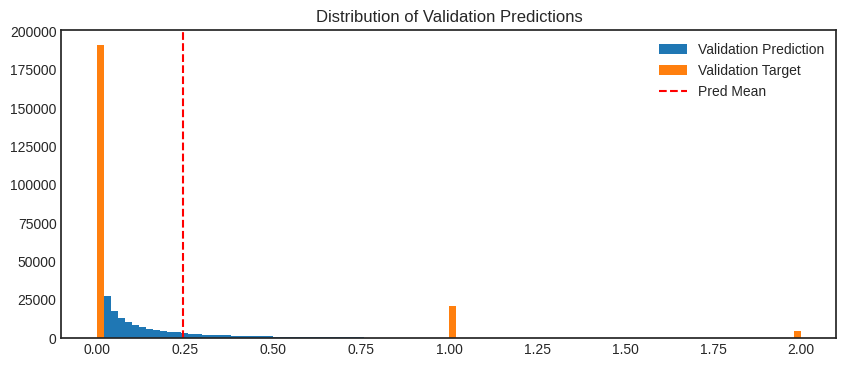

In [18]:
plt.figure(figsize=(10, 4))
plt.hist(val_preds, bins=100, range=(0, 2), label='Validation Prediction')
plt.hist(y_val, bins=100, range=(0, 2), label='Validation Target')
plt.axvline(x=val_preds.mean(), color='r', linestyle='--', label='Pred Mean')
plt.title("Distribution of Validation Predictions")
plt.legend()
plt.show()

## Residual

In [19]:
analysis_df = x_val.copy()
analysis_df['target'] = y_val
analysis_df['pred'] = val_preds
analysis_df['gap'] = analysis_df['target'] - analysis_df['pred']

cols_to_check = ['shop_id', 'item_id', 'item_category_id', 'item_cnt_month_lag_1', 'target', 'pred', 'gap', \
                 'item_age', 'item_shop_age',]

analysis_df.sort_values(by='gap', ascending=False)[cols_to_check].head(10)

,shop_id,item_id,item_category_id,item_cnt_month_lag_1,target,pred,gap,item_age,item_shop_age
8512399,40,17270,37,0,20,0.028264,19.971736,12,0
8512299,40,16629,37,0,20,0.037453,19.962547,11,0
8513395,40,21811,37,0,20,0.037832,19.962168,12,12
8510799,40,11055,37,0,20,0.049375,19.950625,12,5
8519298,42,2431,24,0,20,0.484475,19.515525,10,10
8418171,12,20949,71,0,20,0.652537,19.347463,12,10
8523630,42,20386,72,1,20,0.809623,19.190377,7,7
8521857,42,13241,47,0,20,1.044994,18.955006,0,0
8521862,42,13247,47,0,20,1.044994,18.955006,0,0
8479614,31,13247,47,0,20,1.181665,18.818335,0,0


In [20]:
analysis_df.sort_values(by='gap', ascending=True)[cols_to_check].head(10)

,shop_id,item_id,item_category_id,item_cnt_month_lag_1,target,pred,gap,item_age,item_shop_age
8519650,42,3759,20,0,0,16.005842,-16.005842,0,0
8414030,12,3759,20,0,0,15.494354,-15.494354,0,0
8414051,12,3849,20,0,0,14.306175,-14.306175,0,0
8519671,42,3849,20,0,0,14.209566,-14.209566,0,0
8415173,12,8547,42,20,2,16.111463,-14.111463,1,1
8412890,11,20949,71,20,3,17.066138,-14.066138,12,12
8461559,25,3759,20,0,0,13.007287,-13.007287,0,0
8461580,25,3849,20,0,0,12.892591,-12.892591,0,0
8520794,42,8548,42,20,6,18.145737,-12.145737,1,1
8477423,31,3849,20,0,0,11.949515,-11.949515,0,0


## feature importance

In [21]:
importance = val_lgbm_model.feature_importance(importance_type='gain')
feature_names = val_lgbm_model.feature_name()

feature_imp = pd.DataFrame({
'feature': feature_names,
'importance': importance
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

feature_imp['normalized_importance'] = feature_imp['importance'] / feature_imp['importance'].sum()
feature_imp['cumulative_importance'] = feature_imp['normalized_importance'].cumsum()
feature_imp.tail(10)

,feature,importance,normalized_importance,cumulative_importance
25,category_nov_ratio,949714.848164,0.003862,0.984472
26,item_category_avg_date_sales_lag_1,832717.506417,0.003386,0.987858
27,platform,722650.815739,0.002939,0.990797
28,item_avg_date_sales_diff_2,640997.920634,0.002607,0.993403
29,delta_price_lag,612115.603234,0.002489,0.995892
30,transaction_cnt_lag_2,332401.370981,0.001352,0.997244
31,item_cnt_month_lag_2,320332.970797,0.001303,0.998547
32,item_cnt_month_diff_1,168792.251901,0.000686,0.999233
33,item_cnt_month_lag_3,166975.194041,0.000679,0.999912
34,item_cnt_month_diff_2,21628.678547,0.000088,1.000000


In [22]:
low_col = feature_imp.tail(10)['feature'].to_list()
low_col

['category_nov_ratio',
 'item_category_avg_date_sales_lag_1',
 'platform',
 'item_avg_date_sales_diff_2',
 'delta_price_lag',
 'transaction_cnt_lag_2',
 'item_cnt_month_lag_2',
 'item_cnt_month_diff_1',
 'item_cnt_month_lag_3',
 'item_cnt_month_diff_2']

/tmp/ipykernel_3119/1903301485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


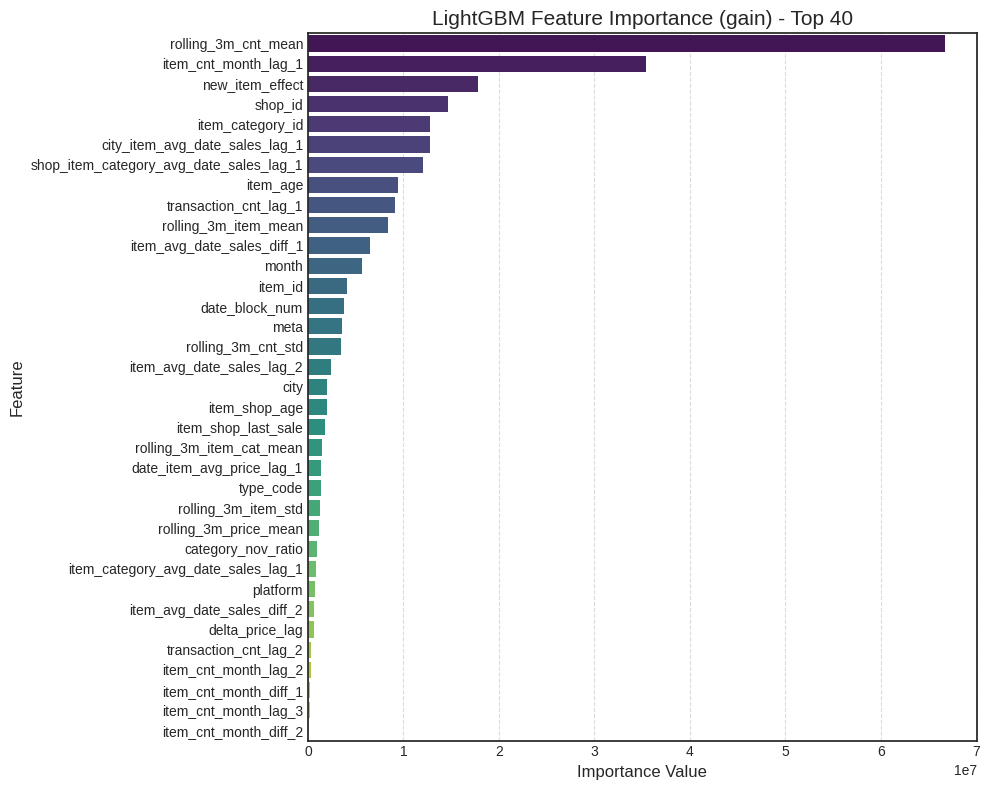

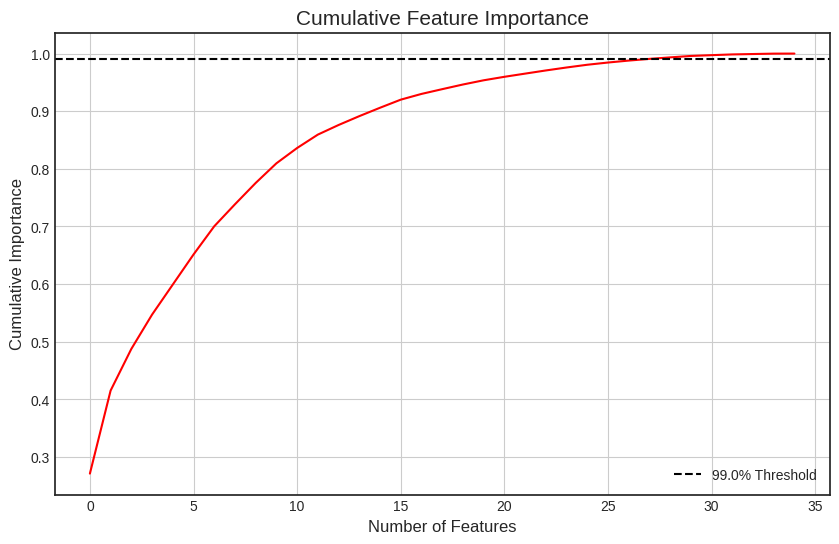

[GAIN] 분석 결과:
- 전체 피처 수: 35
- 99.0% 중요도를 설명하는 피처 수: 28
- 제거 추천 피처 수: 7
Low importance features :  ['item_avg_date_sales_diff_2', 'delta_price_lag', 'transaction_cnt_lag_2', 'item_cnt_month_lag_2', 'item_cnt_month_diff_1', 'item_cnt_month_lag_3', 'item_cnt_month_diff_2']


In [23]:
def analyze_and_filter_features(feature_imp, importance_type='gain', cum_threshold=0.99):
    plt.figure(figsize=(10, 8))    
    sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')
    plt.title(f'LightGBM Feature Importance ({importance_type}) - Top 40', fontsize=15)
    plt.xlabel('Importance Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_imp.index, feature_imp['cumulative_importance'], 'r-')
    plt.axhline(y=cum_threshold, color='k', linestyle='--', label=f'{cum_threshold*100}% Threshold')
    plt.title('Cumulative Feature Importance', fontsize=15)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    cutoff_index = feature_imp[feature_imp['cumulative_importance'] > cum_threshold].index[0]
    selected_features = feature_imp.loc[:cutoff_index, 'feature'].tolist()
    removed_features = feature_imp.loc[cutoff_index+1:, 'feature'].tolist()
    
    print(f"[{importance_type.upper()}] 분석 결과:")
    print(f"- 전체 피처 수: {len(feature_imp)}")
    print(f"- {cum_threshold*100}% 중요도를 설명하는 피처 수: {len(selected_features)}")
    print(f"- 제거 추천 피처 수: {len(removed_features)}")
    
    return feature_imp, removed_features

df_imp, del_cols = analyze_and_filter_features(feature_imp, importance_type='gain', cum_threshold=0.99)
print('Low importance features : ', del_cols)

In [ ]:
# %%time
# def manual_permutation_importance(model, X_val, y_val, target_feature, n_repeats=10):
#     preds_baseline = model.predict(X_val)
#     rmse_baseline = np.sqrt(mean_squared_error(y_val, preds_baseline))
#     print(f"--- Permutation Importance Analysis for: '{target_feature}' ---")
    
#     diffs = []
#     original_column = X_val[target_feature].values.copy()
    
#     try:
#         for i in range(n_repeats):
#             X_val[target_feature] = np.random.permutation(original_column)
#             preds_shuffled = model.predict(X_val)
#             rmse_shuffled = np.sqrt(mean_squared_error(y_val, preds_shuffled))
#             diff = rmse_shuffled - rmse_baseline
#             diffs.append(diff)
            
#     finally:
#         X_val[target_feature] = original_column

#     mean_diff = np.mean(diffs)
#     std_diff = np.std(diffs)
    
#     print(f"RMSE Increase (Importance): {mean_diff:.6f} +/- {std_diff:.6f}")

#     if mean_diff > 0:
#         if mean_diff > 0.0001:
#             print(f">> 결론: '{target_feature}'는 모델 성능 유지에 필수적인 중요한 변수")
#         else:
#             print(f">> 결론: '{target_feature}'는 양수이나 영향력이 미미")
#     else:
#         print(f">> 결론: '{target_feature}'는 모델 성능에 도움이 되지 않거나 노이즈")
        
#     return


# low_cols = ['item_avg_date_sales_diff_1',]
# print('Baseline RMSE: ', val_lgbm_model.best_score['eval']['rmse'])
# for col in low_cols:
#     manual_permutation_importance(val_lgbm_model, x_val, y_val, col)

# # manual_permutation_importance(val_lgbm_model, x_val, y_val, 'item_cnt_month_diff_2')

# Seed Averaging

In [10]:
%%time
seeds = [42, 2025, 777, 1004, 21, 123, 2113, 1347, 13, 47, 1215, 121, 31]
predictions = []
seed_scores = []

for i, seed in enumerate(seeds):
    print(f"Training Model with Seed {seed} | ({i+1}/{len(seeds)})...")
    params = best_params.copy()
    params['random_state'] = seed
    params['feature_fraction_seed'] = seed
    params['bagging_seed'] = seed
    
    model = lgb.train(
        params=params,
        train_set=dtrain,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'eval'],
        num_boost_round=10000, 
        callbacks=[
            early_stopping(stopping_rounds=300),
            log_evaluation(period=0)
        ]
    )

    best_iter = model.best_iteration
    best_score_train = model.best_score['train']['rmse']
    best_score_eval = model.best_score['eval']['rmse']

    if best_score_train > 0.765:
        print(f"Seed {seed} Failed! (Train RMSE: {best_score_train:.4f}) -> Discarding...")
        continue  # 예측값 저장 안 하고 넘어감

    seed_scores.append(best_score_eval)
    print(f"Best Iter: {best_iter} | Train RMSE: {best_score_train:.5f} | Eval RMSE: {best_score_eval:.5f}")
    
    pred = model.predict(x_test, num_iteration=best_iter).clip(0, 20)
    predictions.append(pred)

    if len(predictions) >= 5:
        break

print("-" * 30)
print(f"Average Eval RMSE over {len(seed_scores)} seeds: {np.mean(seed_scores):.5f}")

final_preds = np.mean(predictions, axis=0)
seed_final_preds = np.clip(final_preds, 0, 20)

Training Model with Seed 42 | (1/13)...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1285]	train's rmse: 0.757889	eval's rmse: 0.781274
Best Iter: 1285 | Train RMSE: 0.75789 | Eval RMSE: 0.78127
Training Model with Seed 2025 | (2/13)...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1351]	train's rmse: 0.754805	eval's rmse: 0.787884
Best Iter: 1351 | Train RMSE: 0.75481 | Eval RMSE: 0.78788
Training Model with Seed 777 | (3/13)...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1377]	train's rmse: 0.754032	eval's rmse: 0.783167
Best Iter: 1377 | Train RMSE: 0.75403 | Eval RMSE: 0.78317
Training Model with Seed 1004 | (4/13)...
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[941]	train's rmse: 0.775221	eval's rmse: 0.783615
Seed 1004 Failed! (Train RMSE: 0.7752) -> Discarding...
Trainin

> LB : 0.86287

In [ ]:
# Training Model with Seed 42 | (1/7)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [1686]	train's rmse: 0.741481	eval's rmse: 0.783537
# Best Iter: 1686 | Train RMSE: 0.74148 | Eval RMSE: 0.78354
# Training Model with Seed 2025 | (2/7)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [1029]	train's rmse: 0.769249	eval's rmse: 0.788841
# Seed 2025 Failed! (Train RMSE: 0.7692) -> Discarding...
# Training Model with Seed 777 | (3/7)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [1011]	train's rmse: 0.771253	eval's rmse: 0.785469
# Seed 777 Failed! (Train RMSE: 0.7713) -> Discarding...

In [ ]:
# 처음 실행결과
# Training Model with Seed 42 | (1/5)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [1207]	train's rmse: 0.760112	eval's rmse: 0.783605
# Best Iter: 1207 | Train RMSE: 0.76011 | Eval RMSE: 0.78361
# Training Model with Seed 2025 | (2/5)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [1181]	train's rmse: 0.761167	eval's rmse: 0.787506
# Best Iter: 1181 | Train RMSE: 0.76117 | Eval RMSE: 0.78751
# Training Model with Seed 777 | (3/5)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [1484]	train's rmse: 0.748645	eval's rmse: 0.783052
# Best Iter: 1484 | Train RMSE: 0.74864 | Eval RMSE: 0.78305
# Training Model with Seed 999 | (4/5)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [753]	train's rmse: 0.787119	eval's rmse: 0.784187
# Best Iter: 753 | Train RMSE: 0.78712 | Eval RMSE: 0.78419
# Training Model with Seed 1004 | (5/5)...
# Training until validation scores don't improve for 300 rounds
# Early stopping, best iteration is:
# [1224]	train's rmse: 0.758507	eval's rmse: 0.782604
# Best Iter: 1224 | Train RMSE: 0.75851 | Eval RMSE: 0.78260

# Prediction

In [12]:
val_final_preds = val_lgbm_model.predict(x_test, num_iteration=val_lgbm_model.best_iteration).clip(0, 20)

In [13]:
# x_test는 all_data에서 왔으므로, 여기에 어떤 Shop ID가 들어있는지 확인하고 통일합니다.
df_pred = all_data.loc[all_data['date_block_num'] == 34, ['shop_id', 'item_id']].copy()
df_pred['item_cnt_month'] = val_final_preds

test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

submission = pd.merge(test, df_pred, on=['shop_id', 'item_id'], how='left')
submission[['ID', 'item_cnt_month']].to_csv('./data/submission_val.csv', index=False)

In [14]:
submission.head(10)

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.651881
1,1,5,5320,0.524562
2,2,5,5233,0.887086
3,3,5,5232,0.349501
4,4,5,5268,2.321847
5,5,5,5039,0.827678
6,6,5,5041,0.591519
7,7,5,5046,0.217633
8,8,5,5319,0.735517
9,9,5,5003,0.427275


In [11]:
df_pred = all_data.loc[all_data['date_block_num'] == 34, ['shop_id', 'item_id']].copy()
df_pred['item_cnt_month'] = seed_final_preds

test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

submission = pd.merge(test, df_pred, on=['shop_id', 'item_id'], how='left')
submission[['ID', 'item_cnt_month']].to_csv('./data/submission_seed.csv', index=False)

In [12]:
submission.head(10)

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.636223
1,1,5,5320,0.503206
2,2,5,5233,0.906769
3,3,5,5232,0.369111
4,4,5,5268,2.231806
5,5,5,5039,0.775797
6,6,5,5041,0.609931
7,7,5,5046,0.210724
8,8,5,5319,0.740517
9,9,5,5003,0.404590


In [70]:
# print("33 Prediction Mean:", val_preds.mean()) # 33월 예측
# print("33 Target Mean:", y_val.mean()) # 33월 예측
# print("Test Prediction Mean:", final_preds.mean()) # 34월 예측
# print("+"*50)
# print("33 Prediction std:", val_preds.std()) # 33월 예측
# print("33 Target std:", y_val.std()) # 33월 예측
# print("Test Prediction std:", final_preds.std()) # 34월 예측

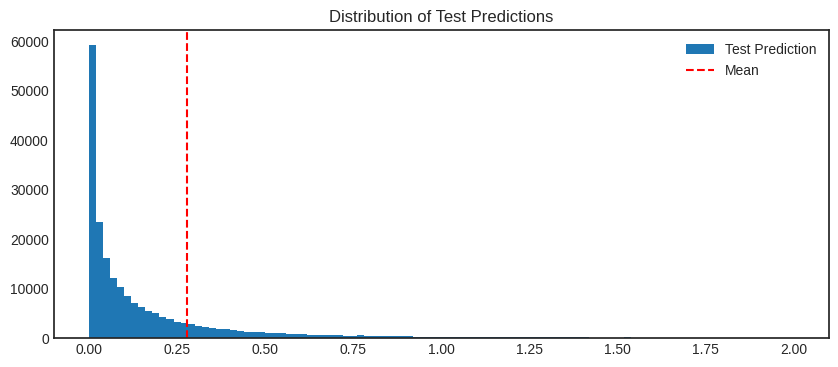

In [72]:
plt.figure(figsize=(10, 4))
plt.hist(val_final_preds, bins=100, range=(0, 2), label='Test Prediction')
plt.axvline(x=val_final_preds.mean(), color='r', linestyle='--', label='Mean')
plt.title("Distribution of Test Predictions")
plt.legend()
plt.show()

# submission

In [15]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submission_val.csv" -m "submission_val"

100%|██████████████████████████████████████| 5.45M/5.45M [00:00<00:00, 11.9MB/s]
Successfully submitted to Predict Future Sales

In [13]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submission_seed.csv" -m "submission_seed"

100%|██████████████████████████████████████| 5.45M/5.45M [00:00<00:00, 12.5MB/s]
Successfully submitted to Predict Future Sales